In [7]:
import pandas as pd
import numpy as np

In [4]:
df = pd.read_csv("health_insurance.csv")
df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [5]:
df.isnull().sum()

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

In [8]:
# Calculate the 75th percentile of Annual Premium to define "High Value"
premium_threshold = df['Annual_Premium'].quantile(0.75)

# Create the Tier label using vectorized operations (efficient)
conditions = [
    # GOLD: High Value AND Interested
    (df['Annual_Premium'] >= premium_threshold) & (df['Response'] == 1),
    # SILVER: High Value BUT Not Interested OR Low Value BUT Interested
    ((df['Annual_Premium'] >= premium_threshold) & (df['Response'] == 0)) | ((df['Annual_Premium'] < premium_threshold) & (df['Response'] == 1)),
    # BRONZE: Low Value AND Not Interested (The largest group)
    (df['Annual_Premium'] < premium_threshold) & (df['Response'] == 0)
]

choices = ['Gold', 'Silver', 'Bronze']

df['Tier'] = np.select(conditions, choices, default='Bronze') # default is safe

# Check the distribution
print(df['Tier'].value_counts())

Tier
Bronze    252996
Silver    114233
Gold       13880
Name: count, dtype: int64


In [9]:
# Define note templates that align with the business scenario and tier logic

gold_notes = [
    "Loyal customer with high-value health policy. Inquired about multi-policy discount for vehicle insurance. Very interested.",
    "High-premium client. Called to ask detailed questions about comprehensive vehicle coverage. Warm lead.",
    "Engaged customer. Already downloaded the brochure for the new vehicle insurance product. Sales team should follow up."
]

silver_notes = [
    "Customer received marketing email for vehicle insurance. Did not open it. Sent a follow-up reminder.",
    "Client asked about price but did not commit. Needs more information on benefits. Medium priority lead.",
    "Renewal coming up. Good opportunity to bundle health and vehicle insurance. Needs a persuasive offer."
]

bronze_notes = [
    "Automated call attempted. Customer was not interested in new products at this time.",
    "Profile suggests low engagement. Only respond to inbound queries. Low priority for telemarketing.",
    "Customer has a basic health plan. Focus on retention rather than upselling. Target with generic ads if needed."
]

def generate_note(row):
    if row['Tier'] == 'Gold':
        return np.random.choice(gold_notes)
    elif row['Tier'] == 'Silver':
        return np.random.choice(silver_notes)
    else:
        return np.random.choice(bronze_notes)

# Apply the function to each row to generate a note
df['Customer_Note'] = df.apply(generate_note, axis=1)

In [10]:
df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Tier,Customer_Note
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1,Gold,Engaged customer. Already downloaded the broch...
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0,Bronze,Customer has a basic health plan. Focus on ret...
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1,Silver,Renewal coming up. Good opportunity to bundle ...
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0,Bronze,Customer has a basic health plan. Focus on ret...
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0,Bronze,Profile suggests low engagement. Only respond ...


In [11]:
# Data Manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Text Processing
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
# from sentence_transformers import SentenceTransformer # Option B

# Model
from xgboost import XGBClassifier

# Evaluation
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

# Download NLTK data
nltk.download('stopwords')
nltk.download('wordnet')

# Set style for plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mayur\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mayur\AppData\Roaming\nltk_data...


In [13]:
# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Tokenize
    words = text.split()
    # Remove stopwords and lemmatize
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    # Join back to string
    return ' '.join(words)

# Apply preprocessing
df['Processed_Note'] = df['Customer_Note'].apply(preprocess_text)
print("Original vs Processed Text Example:")
print("Original:", df['Customer_Note'].iloc[0])
print("Processed:", df['Processed_Note'].iloc[0])

Original vs Processed Text Example:
Original: Engaged customer. Already downloaded the brochure for the new vehicle insurance product. Sales team should follow up.
Processed: engaged customer already downloaded brochure new vehicle insurance product sale team follow


In [15]:
# Define features (X) and target (y)
# First, let's create our features without the text columns we'll process separately
features_to_drop = ['Tier', 'Response', 'Customer_Note']
X_structured = df.drop(features_to_drop, axis=1)
y = df['Tier']

# Get our text data separately
text_data = df['Processed_Note']  # This was created in Step 4

# Split the structured data and target
X_train_struct, X_test_struct, y_train, y_test = train_test_split(
    X_structured, y, test_size=0.2, random_state=42, stratify=y
)

# Split the text data using the same indices
X_train_text = text_data.iloc[X_train_struct.index]
X_test_text = text_data.iloc[X_test_struct.index]

print(f"Training set size: {X_train_struct.shape[0]}")
print(f"Test set size: {X_test_struct.shape[0]}")
print(f"Training text size: {len(X_train_text)}")
print(f"Test text size: {len(X_test_text)}")

# Display a sample to verify
print("\nSample check:")
print("Structured data columns:", X_train_struct.columns.tolist()[:5])
print("Text sample:", X_train_text.iloc[0])

Training set size: 304887
Test set size: 76222
Training text size: 304887
Test text size: 76222

Sample check:
Structured data columns: ['id', 'Gender', 'Age', 'Driving_License', 'Region_Code']
Text sample: profile suggests low engagement respond inbound query low priority telemarketing


In [17]:
# Identify categorical and numerical columns for structured data
categorical_cols = ['Gender', 'Driving_License', 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Region_Code']
numerical_cols = ['Age', 'Annual_Premium', 'Vintage']

# Preprocessing for structured data
preprocessor_structured = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
    ])

# Preprocessing for text data (TF-IDF)
preprocessor_text = TfidfVectorizer(max_features=500, ngram_range=(1, 2))

# Alternative: Using Sentence Transformers (Uncomment if you want to use this)
# pretrained_model = SentenceTransformer('all-MiniLM-L6-v2')
# def get_sentence_embeddings(texts):
#     return pretrained_model.encode(texts)
# X_train_text_embeddings = get_sentence_embeddings(X_train_text.tolist())
# X_test_text_embeddings = get_sentence_embeddings(X_test_text.tolist())

In [18]:
# Fit and transform the structured data
X_train_structured_processed = preprocessor_structured.fit_transform(X_train_struct)
X_test_structured_processed = preprocessor_structured.transform(X_test_struct)

# Fit and transform the text data
X_train_text_processed = preprocessor_text.fit_transform(X_train_text).toarray()
X_test_text_processed = preprocessor_text.transform(X_test_text).toarray()

# Combine structured and text features
X_train_combined = np.hstack((X_train_structured_processed, X_train_text_processed))
X_test_combined = np.hstack((X_test_structured_processed, X_test_text_processed))

print(f"Combined training features shape: {X_train_combined.shape}")
print(f"Combined test features shape: {X_test_combined.shape}")

Combined training features shape: (304887, 224)
Combined test features shape: (76222, 224)


In [20]:
# Convert string labels to numerical codes
from sklearn.preprocessing import LabelEncoder

# Initialize label encoder
label_encoder = LabelEncoder()

# Fit and transform the target labels
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Check the mapping
print("Label mapping:")
for i, class_name in enumerate(label_encoder.classes_):
    print(f"{class_name} -> {i}")

print(f"\nOriginal y_train: {y_train[:5].tolist()}")
print(f"Encoded y_train: {y_train_encoded[:5]}")

Label mapping:
Bronze -> 0
Gold -> 1
Silver -> 2

Original y_train: ['Bronze', 'Silver', 'Bronze', 'Bronze', 'Gold']
Encoded y_train: [0 2 0 0 1]


In [22]:
# Initialize the model
model = XGBClassifier(
    random_state=42,
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='mlogloss',
    use_label_encoder=False
)

# Train the model with ENCODED labels
model.fit(X_train_combined, y_train_encoded)

# Make predictions
y_pred_encoded = model.predict(X_test_combined)

# Convert predictions back to original labels for evaluation
y_pred = label_encoder.inverse_transform(y_pred_encoded)

C:\Users\mayur\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [13:27:58] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 1.0000
Macro F1-Score: 1.0000

Classification Report:
              precision    recall  f1-score   support

      Bronze       1.00      1.00      1.00     50599
        Gold       1.00      1.00      1.00      2776
      Silver       1.00      1.00      1.00     22847

    accuracy                           1.00     76222
   macro avg       1.00      1.00      1.00     76222
weighted avg       1.00      1.00      1.00     76222



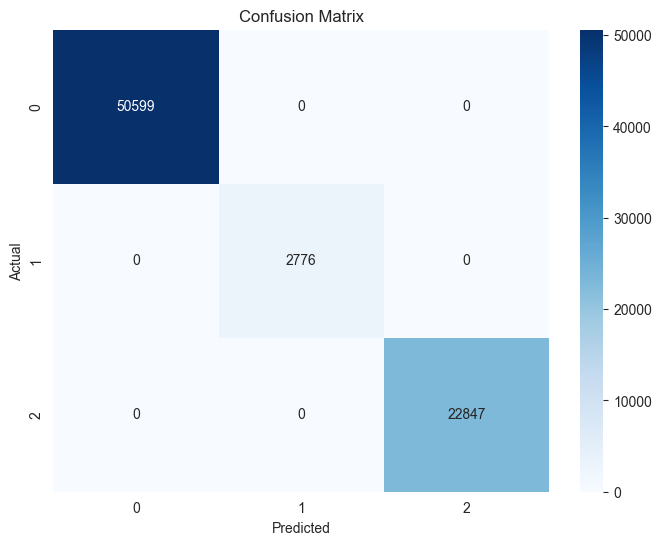

In [23]:
# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')

print(f"Accuracy: {accuracy:.4f}")
print(f"Macro F1-Score: {f1:.4f}")

# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()